<a href="https://colab.research.google.com/github/sooonsyk/ESAA-22-2/blob/main/W12_session_mon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline



In [8]:
electronics_data=pd.read_csv("/content/drive/MyDrive/ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [9]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [10]:
electronics_data.shape

(7824482, 4)

In [11]:
#Taking subset
electronics_data=electronics_data.iloc[:1048576,0:]

In [12]:
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [13]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048576 non-null  object 
 1   productId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [14]:
electronics_data.describe()['Rating'].T #five point summary

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [15]:
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


##Handling Missing value

In [16]:
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


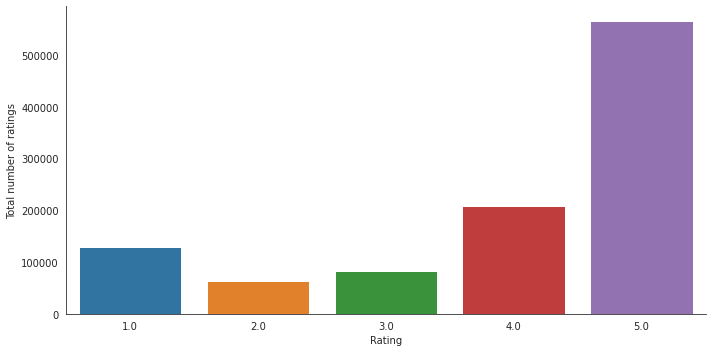

In [17]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")


In [18]:
#Unique useres and products
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048576
Total No of Users   : 786330
Total No of products  : 61894


In [19]:
#Dropping the Timestamp column
electronics_data.drop(['timestamp'], axis=1,inplace=True)

In [20]:
#Analyzing rating
no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [21]:
no_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [22]:
####
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

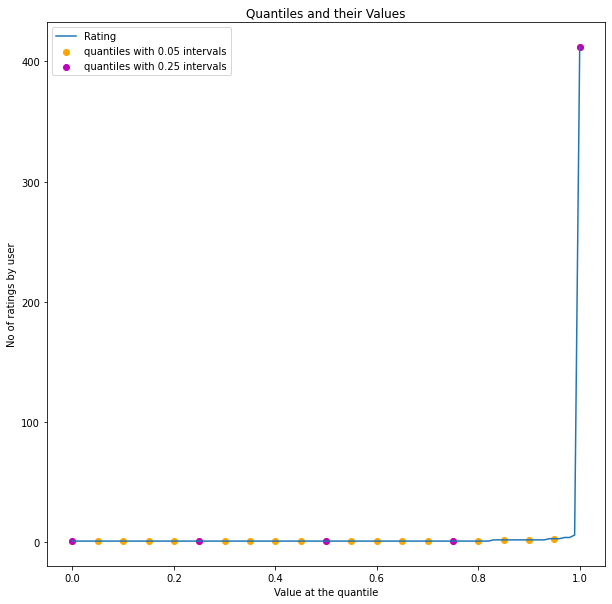

In [23]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [24]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



##popularity bases recommendation
- works with trend
- problem : personalization

In [27]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

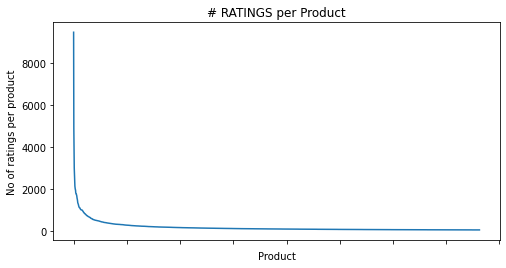

In [28]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [29]:
#Average rating of the product 

new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [30]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [31]:
#Total no of rating for product

new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [32]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [33]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [34]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [35]:
ratings_mean_count['rating_counts'].max()

9487

<Figure size 576x432 with 0 Axes>

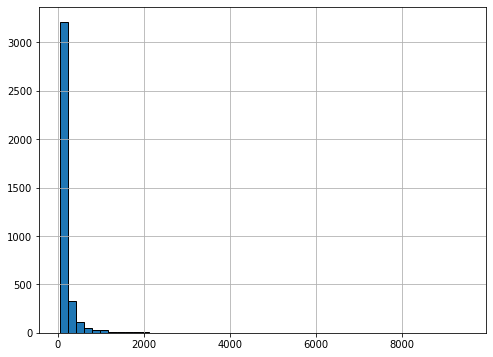

In [36]:
plt.figure(figsize=(8,6))
#### rcParams
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

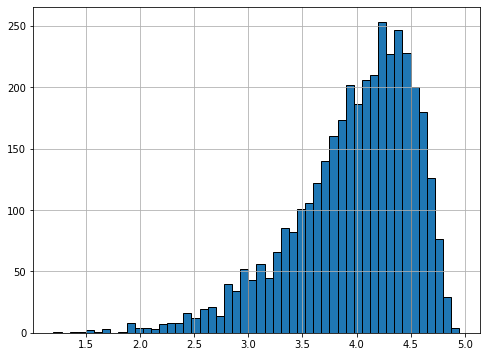

In [37]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

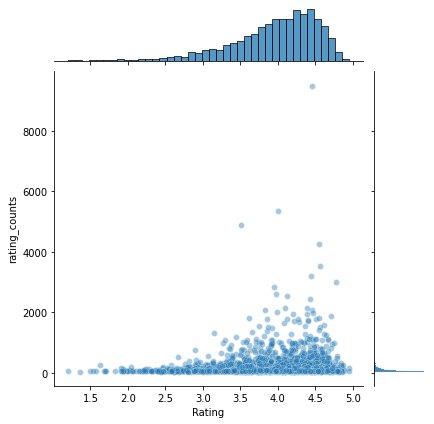

In [38]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

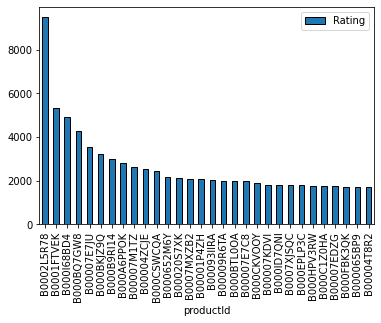

In [39]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

##Collaborative filtering(item-item recommendation)
- aim to fill in the missing entries of a user-item association matrix
- set that best recommendatons come from people who have similar tastes
  - it uses historical item ratings of like-minded people to predict how someone would rate an item

In [42]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 222 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633979 sha256=8b6b203314dcb81061443e896172731e33290e49ccd1ed3e69626db6b5a02238
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [43]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split


In [44]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [45]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [46]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [47]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [48]:
#test_pred

In [49]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3436


1.343641161111319

##Model-based collaborative filtering system
- the goal is to train models to be able to make predictions
- able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach

In [50]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- sparse - fill with 0

In [52]:
ratings_matrix.shape

(9832, 76)

In [53]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X1 = X

In [55]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [56]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [57]:
X.index[75] 

'B00000K135'

In [58]:
#index of product ID purchased by customer

i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [59]:
#correlation for all items with the item purchased by this customer based on items rated by other customers who bought the same product
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [60]:
#Recommending top 25 highly correlated products in sequence
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['7214047977',
 '9573212919',
 '9625993428',
 '9984984354',
 '9985511476',
 'B000001ON6',
 'B00000J0D2',
 'B00000J3NF',
 'B00000J3UJ',
 'B00000JDHV',
 'B00000JII6',
 'B00000JPPI',
 'B00000JSGF']